<a href="https://colab.research.google.com/github/Hou-jing/paper_record_public/blob/main/RERE_%E7%BB%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow==2.1.0

In [ ]:
pip install bert4keras

In [ ]:
!wget https://www.dropbox.com/s/pm4hrky2hxvv2po/cased_L-12_H-768_A-12%20%281%29.zip?dl=0  -O pretrained_bert_models.zip
!unzip -q pretrained_bert_models.zip

bert_model = 'cased_L-12_H-768_A-12'
bert_config_path =  bert_model + '/bert_config.json'


bert_vocab_path = bert_model + '/vocab.txt'
bert_checkpoint_path =  bert_model + '/bert_model.ckpt'

In [ ]:
pip install h5py==2.10.0

In [ ]:
import sys

import tensorflow as tf
sys.path.append('./BERT_tf2')
from bert4keras.models import build_transformer_model

bert_model = 'cased_L-12_H-768_A-12'
bert_config_path =  bert_model + '/bert_config.json'


bert_vocab_path = bert_model + '/vocab.txt'
bert_checkpoint_path =  bert_model + '/bert_model.ckpt'
bert = build_transformer_model(bert_config_path, bert_checkpoint_path, return_keras_model=False) 
bert.model.save('bert_uncased.h5')

Using TensorFlow backend.


In [ ]:

from tensorflow.keras.models import load_model
import keras
model= keras.models.load_model('bert_uncased.h5')

# load_model('bert_uncased.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
import os, sys, time, math, re
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import *

from bert4keras.tokenizers import Tokenizer
from bert4keras.snippets import to_array
from bert4keras.optimizers import Adam, extend_with_piecewise_linear_lr, extend_with_weight_decay
from bert4keras.models import build_transformer_model
from bert4keras.layers import *
from tensorflow.keras.initializers import TruncatedNormal

In [ ]:
import os, sys, time, math, re
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import *

from bert4keras.tokenizers import Tokenizer
from bert4keras.snippets import to_array
from bert4keras.optimizers import Adam, extend_with_piecewise_linear_lr, extend_with_weight_decay
from bert4keras.models import build_transformer_model
from bert4keras.layers import *
from tensorflow.keras.initializers import TruncatedNormal

en_dict_path = r'cased_L-12_H-768_A-12/vocab.txt'
# cn_dict_path = r'../tfhub/chinese_roberta_wwm_ext_L-12_H-768_A-12/vocab.txt'
cn_dict_path = r''
# script_path = os.path.split(os.path.realpath(__file__))[0]
# en_dict_path = os.path.join(script_path, '../tfhub/uncased_L-12_H-768_A-12')
# cn_dict_path = os.path.join(script_path, '../tfhub/chinese_roberta_wwm_ext_L-12_H-768_A-12')
# tokenizer = Tokenizer(cn_dict_path, do_lower_case=True)
language = 'cn'

def switch_to_en():
	global tokenizer, language
	tokenizer = Tokenizer(en_dict_path, do_lower_case=True)
	language = 'en'

def convert_sentences(sents, maxlen=256):
	shape = (2, len(sents), maxlen)
	X = np.zeros(shape, dtype='int32')
	for ii, sent in tqdm(enumerate(sents), desc="Converting sentences"):
		tids, segs = tokenizer.encode(sent, maxlen=maxlen)
		X[0,ii,:len(tids)] = tids
		X[1,ii,:len(segs)] = segs
	return [X[0], X[1]]

def convert_tokens(sents, maxlen=256):
	shape = (2, len(sents), maxlen)
	X = np.zeros(shape, dtype='int32')
	for ii, sent in tqdm(enumerate(sents), desc="Converting tokens"):
		tids = tokenizer.tokens_to_ids(sent)
		X[0,ii,:len(tids)] = tids
	return [X[0], X[1]]

def lock_transformer_layers(transformer, layers=-1):
	def _filter(layers, prefix):
		return [x for x in transformer.layers if x.name.startswith(prefix)]
	if hasattr(transformer, 'model'): transformer = transformer.model
	if layers >= 0:
		print('locking', 'Embedding-*')
		for layer in _filter(transformer, 'Embedding-'):
			layer.trainable = False 
	print('locking', 'Transformer-[%d-%d]-*' % (0, layers-1))
	for index in range(layers):
		for layer in _filter(transformer, 'Transformer-%d-' % index):
			layer.trainable = False 

def unlock_transformer_layers(transformer):
	if hasattr(transformer, 'model'): transformer = transformer.model
	for layer in transformer.layers:
		layer.trainable = True

def get_suggested_optimizer(init_lr=5e-5, total_steps=None):
	lr_schedule = {1000:1, 10000:0.01}
	if total_steps is not None: 
		lr_schedule = {total_steps//10:1, total_steps:0.1}
	optimizer = extend_with_weight_decay(Adam)
	optimizer = extend_with_piecewise_linear_lr(optimizer)
	optimizer_params = {
		'learning_rate': init_lr,
		'lr_schedule': lr_schedule,
		'weight_decay_rate': 0.01,
		'exclude_from_weight_decay': ['Norm', 'bias'],
		'bias_correction': False,
	}
	optimizer = optimizer(**optimizer_params)
	return optimizer

def convert_single_setences(sens, maxlen, tokenizer, details=False):
	X = np.zeros((len(sens), maxlen), dtype='int32')
	datas = []
	for i, s in enumerate(sens):
		tokens = tokenizer.tokenize(s)[:maxlen-2]
		if details:
			otokens = restore_token_list(s, tokens)
			datas.append({'id':i, 's':s, 'otokens':otokens})
		tt = ['[CLS]'] + tokens + ['[SEP]']
		tids = tokenizer.convert_tokens_to_ids(tt)
		X[i,:len(tids)] = tids
	if details: return datas, X
	return X

def build_classifier(classes, bert_h5=None):
	if bert_h5 is None:
		bert_h5 = '../tfhub/chinese_roberta_wwm_ext.h5' if language == 'cn' else '../tfhub/bert_uncased.h5'
	bert = load_model(bert_h5)
	output = Lambda(lambda x: x[:,0], name='CLS-token')(bert.output)
	if classes == 2:
		output = Dense(1, activation='sigmoid', kernel_initializer=TruncatedNormal(stddev=0.02))(output)
	else:
		output = Dense(classes, activation='softmax', kernel_initializer=TruncatedNormal(stddev=0.02))(output)
	model = Model(bert.input, output)
	model.bert_encoder = bert
	return model


## THESE FUNCTIONS ARE TESTED FOR CHS LANGUAGE ONLY
def gen_token_list_inv_pointer(sent, token_list):
	zz = tokenizer.rematch(sent, token_list)
	return [x[0] for x in zz if len(x) > 0]
	sent = sent.lower()
	otiis = []; iis = 0 
	for it, token in enumerate(token_list):
		otoken = token.lstrip('#')
		if token[0] == '[' and token[-1] == ']': otoken = ''
		niis = iis
		while niis <= len(sent):
			if sent[niis:].startswith(otoken): break
			if otoken in '-"' and sent[niis][0] in '—“”': break
			niis += 1
		if niis >= len(sent): niis = iis
		otiis.append(niis)
		iis = niis + max(1, len(otoken))
	for tt, ii in zip(token_list, otiis): print(tt, sent[ii:ii+len(tt.lstrip('#'))])
	for i, iis in enumerate(otiis): 
		assert iis < len(sent)
		otoken = token_list[i].strip('#')
		assert otoken == '[UNK]' or sent[iis:iis+len(otoken)] == otoken
	return otiis

# restore [UNK] tokens to the original tokens
def restore_token_list(sent, token_list):
	if token_list[0] == '[CLS]': token_list = token_list[1:-1]
	invp = gen_token_list_inv_pointer(sent, token_list)
	invp.append(len(sent))
	otokens = [sent[u:v] for u,v in zip(invp, invp[1:])]
	processed = -1
	for ii, tk in enumerate(token_list):
		if tk != '[UNK]': continue
		if ii < processed: continue
		for jj in range(ii+1, len(token_list)):
			if token_list[jj] != '[UNK]': break
		else: jj = len(token_list)
		allseg = sent[invp[ii]:invp[jj]]

		if ii + 1 == jj: continue
		seppts = [0] + [i for i, x in enumerate(allseg) if i > 0 and i+1 < len(allseg) and x == ' ' and allseg[i-1] != ' ']
		if allseg[seppts[-1]:].replace(' ', '') == '': seppts = seppts[:-1]
		seppts.append(len(allseg))
		if len(seppts) == jj - ii + 1:
			for k, (u,v) in enumerate(zip(seppts, seppts[1:])): 
				otokens[ii+k] = allseg[u:v]
		processed = jj + 1
	if invp[0] > 0: otokens[0] = sent[:invp[0]] + otokens[0]
	if ''.join(otokens) != sent:
		raise Exception('restore tokens failed, text and restored:\n%s\n%s' % (sent, ''.join(otokens)))
	return otokens

def gen_word_level_labels(sent, token_list, word_list, pos_list=None):
	otiis = gen_token_list_inv_pointer(sent, token_list)
	wdiis = [];	iis = 0
	for ip, pword in enumerate(word_list):
		niis = iis
		while niis < len(sent):
			if pword == '' or sent[niis:].startswith(pword[0]): break
			niis += 1
		wdiis.append(niis)
		iis = niis + len(pword)
	#for tt, ii in zip(word_list, wdiis): print(tt, sent[ii:ii+len(tt)])

	rlist = [];	ip = 0
	for it, iis in enumerate(otiis):
		while ip + 1 < len(wdiis) and wdiis[ip+1] <= iis: ip += 1
		if iis == wdiis[ip]: rr = 'B'
		elif iis > wdiis[ip]: rr = 'I'
		rr += '-' + pos_list[ip]
		rlist.append(rr)
	#for rr, tt in zip(rlist, token_list): print(rr, tt)
	return rlist

def normalize_sentence(text):
	text = re.sub('[“”]', '"', text)
	text = re.sub('[—]', '-', text)
	text = re.sub('[^\u0000-\u007f\u4e00-\u9fa5\u3001-\u303f\uff00-\uffef·—]', ' \u2800 ', text)
	return text

if __name__ == '__main__':
	#from transformers import BertTokenizer
	#tokenizer = BertTokenizer.from_pretrained('hfl/chinese-bert-wwm')
	switch_to_en()
	sent = 'French is the national language of France where the leaders are FranÃ§ois Hollande and Manuel Valls . Barny cakes , made with sponge cake , can be found in France .'
	tokens = tokenizer.tokenize(sent)
	otokens = restore_token_list(sent, tokens)
	print(tokens)
	print(otokens)
	print('done')

['[CLS]', 'f', '##rench', 'is', 'the', 'national', 'language', 'of', 'f', '##rance', 'where', 'the', 'leaders', 'are', 'f', '##rana', '§', 'o', '##is', 'ho', '##lland', '##e', 'and', 'man', '##uel', 'v', '##all', '##s', '.', 'barn', '##y', 'cakes', ',', 'made', 'with', 's', '##po', '##nge', 'cake', ',', 'can', 'be', 'found', 'in', 'f', '##rance', '.', '[SEP]']
['F', 'rench ', 'is ', 'the ', 'national ', 'language ', 'of ', 'F', 'rance ', 'where ', 'the ', 'leaders ', 'are ', 'F', 'ranÃ', '§', 'o', 'is ', 'Ho', 'lland', 'e ', 'and ', 'Man', 'uel ', 'V', 'all', 's ', '. ', 'Barn', 'y ', 'cakes ', ', ', 'made ', 'with ', 's', 'po', 'nge ', 'cake ', ', ', 'can ', 'be ', 'found ', 'in ', 'F', 'rance ', '.']
done


### utils

In [ ]:
# coding = utf-8

import os, re, sys, random, urllib.parse, json
from collections import defaultdict

def WriteLine(fout, lst):
	fout.write('\t'.join([str(x) for x in lst]) + '\n')

def RM(patt, sr):
	mat = re.search(patt, sr, re.DOTALL | re.MULTILINE)
	return mat.group(1) if mat else ''

try: import requests
except: pass
def GetPage(url, cookie='', proxy='', timeout=5):
	try:
		headers = {'User-Agent':'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/42.0.2311.90 Safari/537.36'}
		if cookie != '': headers['cookie'] = cookie
		if proxy != '': 
			proxies = {'http': proxy, 'https': proxy}
			resp = requests.get(url, headers=headers, proxies=proxies, timeout=timeout)
		else: resp = requests.get(url, headers=headers, timeout=timeout)
		content = resp.content
		try: 
			import chardet
			charset = chardet.detect(content).get('encoding','utf-8')
			if charset.lower().startswith('gb'): charset = 'gbk'
			content = content.decode(charset, errors='replace')
		except:
			headc = content[:min([3000,len(content)])].decode(errors='ignore')
			charset = RM('charset="?([-a-zA-Z0-9]+)', headc)
			if charset == '': charset = 'utf-8'
			content = content.decode(charset, errors='replace')
	except Exception as e:
		print(e)
		content = ''
	return content

def GetJson(url, cookie='', proxy='', timeout=5.0):
	try:
		headers = {'User-Agent':'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/42.0.2311.90 Safari/537.36'}
		if cookie != '': headers['cookie'] = cookie
		if proxy != '': 
			proxies = {'http': proxy, 'https': proxy}
			resp = requests.get(url, headers=headers, proxies=proxies, timeout=timeout)
		else: resp = requests.get(url, headers=headers, timeout=timeout)
		return resp.json() 
	except Exception as e:
		print(e)
		content = {}
	return content

def FindAllHrefs(url, content=None, regex=''):
	ret = set()
	if content == None: content = GetPage(url)
	patt = re.compile('href="?([a-zA-Z0-9-_:/.%]+)')
	for xx in re.findall(patt, content):
		ret.add( urllib.parse.urljoin(url, xx) )
	if regex != '': ret = (x for x in ret if re.match(regex, x))
	return list(ret)

def Translate(txt):
	postdata = {'from': 'en', 'to': 'zh', 'transtype': 'realtime', 'query': txt}
	url = "http://fanyi.baidu.com/v2transapi"
	try:
		resp = requests.post(url, data=postdata, 
					   headers={'Referer': 'http://fanyi.baidu.com/'})
		ret = resp.json()
		ret = ret['trans_result']['data'][0]['dst']
	except Exception as e:
		print(e)
		ret = ''
	return ret

def IsChsStr(z):
	return re.search('^[\u4e00-\u9fa5]+$', z) is not None

def FreqDict2List(dt):
	return sorted(dt.items(), key=lambda d:d[-1], reverse=True)

def SelectRowsbyCol(fn, ofn, st, num = 0):
	with open(fn, encoding = "utf-8") as fin:
		with open(ofn, "w", encoding = "utf-8") as fout:
			for line in (ll for ll in fin.read().split('\n') if ll != ""):
				if line.split('\t')[num] in st:
					fout.write(line + '\n')

def MergeFiles(dir, objfile, regstr = ".*"):
	with open(objfile, "w", encoding = "utf-8") as fout:
		for file in os.listdir(dir):
			if re.match(regstr, file):
				with open(os.path.join(dir, file), encoding = "utf-8") as filein:
					fout.write(filein.read())

def JoinFiles(fnx, fny, ofn):
	with open(fnx, encoding = "utf-8") as fin:
		lx = [vv for vv in fin.read().split('\n') if vv != ""]
	with open(fny, encoding = "utf-8") as fin:
		ly = [vv for vv in fin.read().split('\n') if vv != ""]
	with open(ofn, "w", encoding = "utf-8") as fout:
		for i in range(min(len(lx), len(ly))):
			fout.write(lx[i] + "\t" + ly[i] + "\n")

				
def RemoveDupRows(file, fobj='*'):
	st = set()
	if fobj == '*': fobj = file
	with open(file, encoding = "utf-8") as fin:
		for line in fin.read().split('\n'):
			if line == "": continue
			st.add(line)
	with open(fobj, "w", encoding = "utf-8") as fout:
		for line in st:
			fout.write(line + '\n')
			
def LoadCSV(fn):
	ret = []
	with open(fn, encoding='utf-8') as fin:
		for line in fin:
			lln = line.rstrip('\r\n').split('\t')
			ret.append(lln)
	return ret

def LoadCSVg(fn):
	with open(fn, encoding='utf-8') as fin:
		for line in fin:
			lln = line.rstrip('\r\n').split('\t')
			yield lln

def SaveCSV(csv, fn):
	with open(fn, 'w', encoding='utf-8') as fout:
		for x in csv:
			WriteLine(fout, x)

def SplitTables(fn, limit=3):
	rst = set()
	with open(fn, encoding='utf-8') as fin:
		for line in fin:
			lln = line.rstrip('\r\n').split('\t')
			rst.add(len(lln))
	if len(rst) > limit: 
		print('%d tables, exceed limit %d' % (len(rst), limit))
		return
	for ii in rst:
		print('%d columns' % ii)
		with open(fn.replace('.txt', '') + '.split.%d.txt' % ii, 'w', encoding='utf-8') as fout:
			with open(fn, encoding='utf-8') as fin:
				for line in fin:
					lln = line.rstrip('\r\n').split('\t')
					if len(lln) == ii:
						fout.write(line)

def LoadSet(fn):
	with open(fn, encoding="utf-8") as fin:
		st = set(ll for ll in fin.read().split('\n') if ll != "")
	return st

def LoadList(fn):
	with open(fn, encoding="utf-8") as fin:
		st = list(ll for ll in fin.read().split('\n') if ll != "")
	return st

def LoadJsonsg(fn): return map(json.loads, LoadListg(fn))
def LoadJsons(fn): return list(LoadJsonsg(fn))

def LoadListg(fn):
	with open(fn, encoding="utf-8") as fin:
		for ll in fin:
			ll = ll.strip()
			if ll != '': yield ll

def LoadDict(fn, func=str):
	dict = {}
	with open(fn, encoding = "utf-8") as fin:
		for lv in (ll.split('\t', 1) for ll in fin.read().split('\n') if ll != ""):
			dict[lv[0]] = func(lv[1])
	return dict

def SaveDict(dict, ofn, output0 = True):
	with open(ofn, "w", encoding = "utf-8") as fout:
		for k in dict.keys():
			if output0 or dict[k] != 0:
				fout.write(str(k) + "\t" + str(dict[k]) + "\n")
			
def SaveList(st, ofn):
	with open(ofn, "w", encoding = "utf-8") as fout:
		for k in st:
			fout.write(str(k) + "\n")

def ListDirFiles(dir, filter=None):
	if filter is None: 
		return [os.path.join(dir, x) for x in os.listdir(dir)]
	return [os.path.join(dir, x) for x in os.listdir(dir) if filter(x)]

def ProcessDir(dir, func, param):
	for file in os.listdir(dir):
		print(file)
		func(os.path.join(dir, file), param)

def GetLines(fn):
	with open(fn, encoding = "utf-8", errors = 'ignore') as fin:
		lines = list(map(str.strip, fin.readlines()))
	return lines

				
def SortRows(file, fobj, cid, type=int, rev = True):
	lines = LoadCSV(file)
	dat = []
	for dv in lines:
		if len(dv) <= cid: continue
		dat.append((type(dv[cid]), dv))
	with open(fobj, "w", encoding = "utf-8") as fout:
		for dd in sorted(dat, reverse = rev):
			fout.write('\t'.join(dd[1]) + '\n')

def SampleRows(file, fobj, num):
	zz = list(open(file, encoding='utf-8'))
	num = min([num, len(zz)])
	zz = random.sample(zz, num)
	with open(fobj, 'w', encoding='utf-8') as fout:
		for xx in zz: fout.write(xx)

def SetProduct(file1, file2, fobj):
	l1, l2 = GetLines(file1), GetLines(file2)
	with open(fobj, 'w', encoding='utf-8') as fout:
		for z1 in l1:
			for z2 in l2:
				fout.write(z1 + z2 + '\n')

class TokenList:
	def __init__(self, file, low_freq=2, source=None, func=None, save_low_freq=2, special_marks=[]):
		if not os.path.exists(file):
			tdict = defaultdict(int)
			for i, xx in enumerate(special_marks): tdict[xx] = 100000000 - i
			for xx in source:
				for token in func(xx): tdict[token] += 1
			tokens = FreqDict2List(tdict)
			tokens = [x for x in tokens if x[1] >= save_low_freq]
			SaveCSV(tokens, file)
		self.id2t = ['<PAD>', '<UNK>'] + \
			[x for x,y in LoadCSV(file) if float(y) >= low_freq]
		self.t2id = {v:k for k,v in enumerate(self.id2t)}
	def get_id(self, token): return self.t2id.get(token, 1)
	def get_token(self, ii): return self.id2t[ii]
	def get_num(self): return len(self.id2t)

def CalcF1(correct, output, golden):
	prec = correct / max(output, 1);  reca = correct / max(golden, 1);
	f1 = 2 * prec * reca / max(1e-9, prec + reca)
	pstr = 'Prec: %.4f %d/%d, Reca: %.4f %d/%d, F1: %.4f' % (prec, correct, output, reca, correct, golden, f1)
	return pstr

def Upgradeljqpy(url=None):
	if url is None: url = 'http://gdm.fudan.edu.cn/files1/ljq/ljqpy.py'
	dirs = [dir for dir in reversed(sys.path) if os.path.isdir(dir) and 'ljqpy.py' in os.listdir(dir)]
	if len(dirs) == 0: raise Exception("package directory no found")
	dir = dirs[0]
	print('downloading ljqpy.py from %s to %s' % (url, dir))
	resp = requests.get(url)
	if b'Upgradeljqpy' not in resp.content: raise Exception('bad file')
	with open(os.path.join(dir, 'ljqpy.py'), 'wb') as fout:
		fout.write(resp.content)
	print('success')

def sql(cmd=''):
	if cmd == '': cmd = input("> ")
	cts = [x for x in cmd.strip().lower()]
	instr = False
	for i in range(len(cts)):
		if cts[i] == '"' and cts[i-1] != '\\': instr = not instr
		if cts[i] == ' ' and instr: cts[i] = "&nbsp;"
	cmds = "".join(cts).split(' ')
	keyw = { 'select', 'from', 'to', 'where' }
	ct, kn = {}, ''
	for xx in cmds:
		if xx in keyw: kn = xx
		else: ct[kn] = ct.get(kn, "") + " " + xx

	for xx in ct.keys():
		ct[xx] = ct[xx].replace("&nbsp;", " ").strip()

	if ct.get('where', "") == "": ct['where'] = 'True'

	if os.path.isdir(ct['from']): fl = [os.path.join(ct['from'], x) for x in os.listdir(ct['from'])]
	else: fl = ct['from'].split('+')

	if ct.get('to', "") == "": ct['to'] = 'temp.txt'

	for xx in ct.keys():
		print(xx + " : " + ct[xx])

	total = 0
	with open(ct['to'], 'w', encoding = 'utf-8') as fout:
		for fn in fl:
			print('selecting ' + fn)
			for xx in open(fn, encoding = 'utf-8'):
				x = xx.rstrip('\r\n').split('\t')
				if eval(ct['where']):
					if ct['select'] == '*': res = "\t".join(x) + '\n'
					else: res = "\t".join(eval('[' + ct['select'] + ']')) + '\n'
					fout.write(res)
					total += 1

	print('completed, ' + str(total) + " records")

def cmd():
	while True:
		cmd = input("> ")
		sql(cmd)
		

In [ ]:
import os, sys, time, re, json
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
sys.path.append('./BERT_tf2')
sys.path.append('./')
# import torch
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from bert4keras.backend import keras, K
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import json

### 文件下载

In [ ]:
!wget https://www.dropbox.com/s/abskd89mu9me54g/NYT_10.zip?dl=0 -O desktop.zip
!unzip -q desktop.zip

In [ ]:
import json
dic=dict()
dic['NYT10-HRL']={'thre_rc':0.4,'thre_ee':0.2}
dic['NYT11-HRL']={'thre_rc':0.56,'thre_ee':0.55}
dic['NYT21-HRL']={'thre_rc':0.56,'thre_ee':0.55}
dic['ske2019']={'thre_rc':0.5,'thre_ee':0.3}
# with open('config.json','w') as f:
print(dic)
with open('config.json','w') as f:
    json.dump(dic,f)

{'NYT10-HRL': {'thre_rc': 0.4, 'thre_ee': 0.2}, 'NYT11-HRL': {'thre_rc': 0.56, 'thre_ee': 0.55}, 'NYT21-HRL': {'thre_rc': 0.56, 'thre_ee': 0.55}, 'ske2019': {'thre_rc': 0.5, 'thre_ee': 0.3}}


In [ ]:


dname = sys.argv[1]
trains = LoadJsons('new_train.json')
valids = LoadJsons('new_valid.json')
tests = LoadJsons('new_test.json')
thre_rc=0.2
thre_ee=0.4
try:
    with open('config.json','r') as f:
        thres=json.load(f)
        thre_rc=thres[f'{dname}']['thre_rc']
        thre_ee=thres[f'{dname}']['thre_ee']
except:pass
if not os.path.isdir('model/'+dname): os.makedirs('model/'+dname)

def wdir(x): return 'model/'+dname+'/BCE_'+x

rels = TokenList(wdir('rels.txt'), 1, trains, lambda z:[x['label'] for x in z['relationMentions']])
print('rels:', rels.get_num())

if not dname == 'ske2019': 
    switch_to_en()


LOSS='BCE'
maxlen = 128

def cpu_mid_loss(y_true,y_pred,mid=0,pi=0.1,**kwargs):
    eps = 1e-6
    y_true=K.cast(y_true, 'float32')
    pos = K.sum(y_true * y_pred, 1) / K.maximum(eps, K.sum(y_true, 1))
    pos = - K.log(pos + eps)
    neg = K.sum((1-y_true) * y_pred, 1) / K.maximum(eps, K.sum(1-y_true, 1))
    neg = K.abs(neg-mid) 
    neg = - K.log(1 - neg + eps)
    return K.mean(pi*pos + neg)

def dgcnn_block(x, dim, dila=1):
    y1 = Conv1D(dim, 3, padding='same', dilation_rate=dila)(x)
    y2 = Conv1D(dim, 3, padding='same', dilation_rate=dila, activation='sigmoid')(x)
    yy = multiply([y1, y2])
    if yy.shape[-1] == x.shape[-1]: yy = add([yy, x])
    return yy
    
def neg_log_mean_loss(y_true, y_pred):
    eps = 1e-6
    pos = - K.sum(y_true * K.log(y_pred+eps), 1) / K.maximum(eps, K.sum(y_true, 1))
    neg = K.sum((1-y_true) * y_pred, 1) / K.maximum(eps, K.sum(1-y_true, 1))
    neg = - K.log(1 - neg + eps)
    return K.mean(pos + neg * 15)

def FindValuePos(sent, value):
    ret = [];  
    value = value.replace(' ', '').lower()
    if value == '': return ret
    ss = [x.replace(' ', '').lower() for x in sent]
    for k, v in enumerate(ss):
        if not value.startswith(v): continue
        vi = 0
        for j in range(k, len(ss)):
            if value[vi:].startswith(ss[j]):
                vi += len(ss[j])
                if vi == len(value):
                    ret.append( (k, j+1) )
            else: break
    return ret

def GetTopSpans(tokens, rr, K=40):
    cands = defaultdict(float)
    start_indexes = sorted(enumerate(rr[:,0]), key=lambda x:-x[1])[:K]
    end_indexes = sorted(enumerate(rr[:,1]), key=lambda x:-x[1])[:K]
    for start_index, start_score in start_indexes:
        if start_score < 0.1: continue
        if start_index >= len(tokens): continue
        for end_index, end_score in end_indexes:
            if end_score < 0.1: continue
            if end_index >= len(tokens): continue
            if end_index < start_index: continue
            length = end_index - start_index + 1
            if length > 40: continue
            ans = ''.join(tokens[start_index:end_index+1]).strip()
            if '》' in ans: continue
            if '、' in ans and len(ans.split('、')) > 2 and '，' not in ans and ',' not in ans:
                aas = ans.split('、')
                for aa in aas: cands[aa.strip()] += start_score * end_score / len(aas)
                continue
            cands[ans] += start_score * end_score

    cand_list = sorted(cands.items(), key=lambda x:len(x[0]))
    removes = set()
    contains = {}
    for i, (x, y) in enumerate(cand_list):
        for j, (xx, yy) in enumerate(cand_list[:i]):
            if xx in x and len(xx) < len(x):
                contains.setdefault(x, []).append(xx)

    for i, (x, y) in enumerate(cand_list):
        sump = sum(cands[z] for z in contains.get(x, []) if z not in removes)
        suml = sum(len(z) for z in contains.get(x, []) if z not in removes)
        if suml > 0: sump = sump * min(1, len(x) / suml)
        if sump > y: removes.add(x)
        else:
            for z in contains.get(x, []): removes.add(z)

    ret = [x for x in cand_list if x[0] not in removes]
    ret.sort(key=lambda x:-x[1])
    return ret[:K]

def GenTriple(p, x, y):
    return {'label':p, 'em1Text':x, 'em2Text':y}



rels: 31


In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [ ]:
import keras
model= keras.models.load_model('bert_uncased.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
import tensorflow
from keras.layers import *
from tensorflow.keras.optimizers import Adam
from keras.models import Model
import keras.backend as K
from keras.callbacks import Callback


In [ ]:
def get_suggested_optimizer(init_lr=5e-5, total_steps=None):
	lr_schedule = {1000:1, 10000:0.01}
	if total_steps is not None: 
		lr_schedule = {total_steps//10:1, total_steps:0.1}
	optimizer = extend_with_weight_decay(Adam)
	optimizer = extend_with_piecewise_linear_lr(optimizer)
	optimizer_params = {
		'learning_rate': init_lr,
		'lr_schedule': lr_schedule,
		'weight_decay_rate': 0.01,
		'exclude_from_weight_decay': ['Norm', 'bias']
	}
	optimizer = optimizer(**optimizer_params)
	return optimizer

### RC Model

In [ ]:
class RCModel:
    def __init__(self):
        # if not dname == 'ske2019':
        self.bert = keras.models.load_model('bert_uncased.h5')
        # else:            
        #     self.bert = load_model('./chinese_roberta_wwm_ext.h5')
        xx = Lambda(lambda x:x[:,0])(self.bert.output)
        pos = Dense(rels.get_num(), activation='sigmoid')(xx)
        self.model = Model(inputs=self.bert.input, outputs=pos)
        lock_transformer_layers(self.bert, 8)
        self.model_ready = False

    def gen_golden_y(self, datas):
        for dd in datas:
            dd['rc_obj'] = list(set(x['label'] for x in dd.get('relationMentions', [])))
        
    def make_model_data(self, datas):
        self.gen_golden_y(datas)
        for dd in tqdm(datas, desc='tokenize'):
            s = dd['sentText']
            tokens = tokenizer.tokenize(s, maxlen=maxlen)
            dd['tokens'] = tokens
        N = len(datas)
        X = [np.zeros((N, maxlen), dtype='int32'), np.zeros((N, maxlen), dtype='int32')]
        Y = np.zeros((N, rels.get_num()))
        for i, dd in enumerate(tqdm(datas, desc='gen XY', total=N)):
            tokens = dd['tokens']
            tokens = dd['tokens']
            X[0][i][:len(tokens)] = tokenizer.tokens_to_ids(tokens)
            for x in dd['rc_obj']: Y[i][rels.get_id(x)] = 1
        return X, Y

    def load_model(self):
        self.model.load_weights(wdir('rc.h5'))
        self.model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
        self.model_ready = True

    def train(self, datas, batch_size=32, epochs=10):
        self.X, self.Y = self.make_model_data(datas)
        self.optimizer = get_suggested_optimizer(5e-5, len(datas) * epochs // batch_size)
        if LOSS=='BCE':
            self.model.compile(self.optimizer, 'binary_crossentropy', metrics=['accuracy'])
        elif LOSS=='MID':
                from functools import partial
                PI_RC = np.sum(self.Y)/np.prod(self.Y.shape)
                FN_RATIO = 0.05
                mid_loss = partial(cpu_mid_loss, mid=PI_RC*(1+FN_RATIO),pi=0.04)
                self.model.compile(self.optimizer, mid_loss, metrics=['accuracy'])
        self.cb_mcb = keras.callbacks.ModelCheckpoint(wdir('rc.h5'), save_weights_only=True, verbose=1)
        self.model.fit(self.X, self.Y, batch_size, epochs=epochs, shuffle=True, 
                    validation_split=0.01, callbacks=[self.cb_mcb])
        self.model_ready = True
                
    def get_output(self, datas, pred, threshold=0.5):
        for dd, pp in zip(datas, pred):
            dd['rc_pred'] = list(rels.get_token(i) for i, sc in enumerate(pp) if sc > threshold)

    def evaluate(self, datas):
        ccnt, gcnt, ecnt = 0, 0, 0
        for dd in datas:
            plabels = set(dd['rc_pred'])
            ecnt += len(plabels)
            gcnt += len(set(dd['rc_obj']))
            ccnt += len(plabels & set(dd['rc_obj']))
        return CalcF1(ccnt, ecnt, gcnt)
#(correct, output, golden)
    def predict(self, datas, threshold=0.5, ofile=None):
        if not self.model_ready: self.load_model()
        self.vX, self.vY = self.make_model_data(datas)
        pred = self.model.predict(self.vX, batch_size=64, verbose=1)
        self.get_output(datas, pred, threshold)
        f1str = self.evaluate(datas)
        if ofile is not None:
            SaveList(map(lambda x:json.dumps(x, ensure_ascii=False), datas), wdir(ofile))
        print(f1str)
        return f1str
rc = RCModel()
rc.train(trains, batch_size=32, epochs=1)
rc.predict(tests, threshold=thre_rc, ofile='valid_rc.json')

/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


locking Embedding-*
locking Transformer-[0-7]-*


gen XY: 100%|██████████| 69988/69988 [00:02<00:00, 34317.65it/s]


Train on 69288 samples, validate on 700 samples
Epoch 1/20
 3936/69288 [>.............................] - ETA: 9:36 - loss: 0.1326 - accuracy: 0.9530

KeyboardInterrupt: ignored

In [ ]:
class RCModel:
    def __init__(self):
        # if not dname == 'ske2019':
        self.bert = keras.models.load_model('bert_uncased.h5')
        # else:            
        #     self.bert = load_model('./chinese_roberta_wwm_ext.h5')
        xx = Lambda(lambda x:x[:,0])(self.bert.output)
        pos = Dense(rels.get_num(), activation='sigmoid')(xx)
        self.model = Model(inputs=self.bert.input, outputs=pos)
        lock_transformer_layers(self.bert, 8)
        self.model_ready = False

    def gen_golden_y(self, datas):
        for dd in datas:
            dd['rc_obj'] = list(set(x['label'] for x in dd.get('relationMentions', [])))
        
    def make_model_data(self, datas):
        self.gen_golden_y(datas)
        for dd in tqdm(datas, desc='tokenize'):
            s = dd['sentText']
            tokens = tokenizer.tokenize(s, maxlen=maxlen)
            dd['tokens'] = tokens
        N = len(datas)
        X = [np.zeros((N, maxlen), dtype='int32'), np.zeros((N, maxlen), dtype='int32')]
        Y = np.zeros((N, rels.get_num()))
        for i, dd in enumerate(tqdm(datas, desc='gen XY', total=N)):
            tokens = dd['tokens']
            tokens = dd['tokens']
            X[0][i][:len(tokens)] = tokenizer.tokens_to_ids(tokens)
            for x in dd['rc_obj']: Y[i][rels.get_id(x)] = 1
        return X, Y

    def load_model(self):
        self.model.load_weights(wdir('rc.h5'))
        self.model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
        self.model_ready = True

    def train(self, datas, batch_size=32, epochs=10):
        self.X, self.Y = self.make_model_data(datas)
        self.optimizer = get_suggested_optimizer(5e-5, len(datas) * epochs // batch_size)
        if LOSS=='BCE':
            self.model.compile(self.optimizer, 'binary_crossentropy', metrics=['accuracy'])
        elif LOSS=='MID':
                from functools import partial
                PI_RC = np.sum(self.Y)/np.prod(self.Y.shape)
                FN_RATIO = 0.05
                mid_loss = partial(cpu_mid_loss, mid=PI_RC*(1+FN_RATIO),pi=0.04)
                self.model.compile(self.optimizer, mid_loss, metrics=['accuracy'])
        self.cb_mcb = keras.callbacks.ModelCheckpoint(wdir('rc.h5'), save_weights_only=True, verbose=1)
        self.model.fit(self.X, self.Y, batch_size, epochs=epochs, shuffle=True, 
                    validation_split=0.01, callbacks=[self.cb_mcb])
        self.model_ready = True
                
    def get_output(self, datas, pred, threshold=0.5):
        for dd, pp in zip(datas, pred):
            dd['rc_pred'] = list(rels.get_token(i) for i, sc in enumerate(pp) if sc > threshold)

    def evaluate(self, datas):
        ccnt, gcnt, ecnt = 0, 0, 0
        for dd in datas:
            plabels = set(dd['rc_pred'])
            ecnt += len(plabels)
            gcnt += len(set(dd['rc_obj']))
            ccnt += len(plabels & set(dd['rc_obj']))
        return CalcF1(ccnt, ecnt, gcnt)
#(correct, output, golden)
    def predict(self, datas, threshold=0.5, ofile=None):
        if not self.model_ready: self.load_model()
        self.vX, self.vY = self.make_model_data(datas)
        pred = self.model.predict(self.vX, batch_size=64, verbose=1)
        self.get_output(datas, pred, threshold)
        f1str = self.evaluate(datas)
        if ofile is not None:
            SaveList(map(lambda x:json.dumps(x, ensure_ascii=False), datas), wdir(ofile))
        print(f1str)
        return f1str
rc = RCModel()
rc.train(trains, batch_size=32, epochs=1)
rc.predict(tests, threshold=thre_rc, ofile='valid_rc.json')

/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


locking Embedding-*
locking Transformer-[0-7]-*


gen XY: 100%|██████████| 69988/69988 [00:02<00:00, 27879.15it/s]


Train on 69288 samples, validate on 700 samples
Epoch 1/1
69288/69288 [==============================] - 563s 8ms/step - loss: 0.0525 - accuracy: 0.9812 - val_loss: 0.0313 - val_accuracy: 0.9884

Epoch 00001: saving model to model/-f/BCE_rc.h5


gen XY: 100%|██████████| 4006/4006 [00:00<00:00, 31448.11it/s]


4006/4006 [==============================] - 18s 5ms/step
Prec: 0.7605 4588/6033, Reca: 0.8154 4588/5627, F1: 0.7870


'Prec: 0.7605 4588/6033, Reca: 0.8154 4588/5627, F1: 0.7870'

### EE Model

In [ ]:
class EEModel:
    def __init__(self):
        # if not dname == 'ske2019':
        #     self.bert = load_model('./bert_uncased.h5')
        # else:            
        #     self.bert = load_model('./chinese_roberta_wwm_ext.h5')
        self.bert = keras.models.load_model('bert_uncased.h5')
        pos = Dense(4, activation='sigmoid')(self.bert.output)
        self.model = Model(inputs=self.bert.input, outputs=pos)
        lock_transformer_layers(self.bert, 3)
        self.model_ready = False
        
    def make_model_data(self, datas):
        if 'tokens' not in datas[0]:
            for dd in tqdm(datas, desc='tokenize'):
                s = dd['sentText']
                tokens = tokenizer.tokenize(s, maxlen=maxlen)
                dd['tokens'] = tokens
        N = 0
        for dd in tqdm(datas, desc='matching'):
            otokens = restore_token_list(dd['sentText'], dd['tokens'])
            dd['otokens'] = otokens
            ys = {}
            if 'rc_pred' in dd:
                plist = dd['rc_pred']
            else:
                for x in dd.get('relationMentions', []):
                    ys.setdefault(x['label'], []).append( (x['em1Text'], x['em2Text']) )
                plist = sorted(ys.keys())
            yys = []
            for pp in plist:
                spos, opos = [], []
                for s, o in ys.get(pp, []):
                    ss, oo = FindValuePos(otokens, s), FindValuePos(otokens, o)
                    if len(ss) == 0 and len(oo) == 0: continue
                    spos.extend(ss)
                    opos.extend(oo)
                yys.append( {'pp':pp, 'spos':spos, 'opos':opos} )
            dd['ee_obj'] = yys
            N += len(yys)
        X = [np.zeros((N, maxlen), dtype='int32'), np.zeros((N, maxlen), dtype='int8')]
        Y = np.zeros((N, maxlen, 4), dtype='int8')
        ii = 0
        for dd in tqdm(datas, desc='gen EE XY'):
            tokens = dd['tokens']
            for item in dd['ee_obj']:
                pp, spos, opos = item['pp'], item['spos'], item['opos']
                first = tokenizer.tokenize(pp)
                offset = len(first)
                item['offset'] = offset
                tts = (first + tokens[1:])[:maxlen]
                X[0][ii][:len(tts)] = tokenizer.tokens_to_ids(tts)#rel+tokens
                X[1][ii][offset:offset+len(tokens)-1] = 1#atten_mask
                for u, v in spos:#对应每个关系的subject_pos
                    try:
                        Y[ii][offset+u,0] = 1
                        Y[ii][offset+v-1,1] = 1
                    except: pass
                for u, v in opos:
                    try:
                        Y[ii][offset+u,2] = 1
                        Y[ii][offset+v-1,3] = 1
                    except: pass
                ii += 1
        return X, Y

    def train(self, datas, batch_size=32, epochs=10):
        self.X, self.Y = self.make_model_data(datas)
        self.optimizer = get_suggested_optimizer(5e-5, len(datas) * epochs // batch_size)
        self.model.compile(self.optimizer, 'binary_crossentropy', metrics=['accuracy'])
        self.cb_mcb = keras.callbacks.ModelCheckpoint(wdir('ee.h5'), save_weights_only=True, verbose=1)
        self.model.fit(self.X, self.Y, batch_size, epochs=epochs, shuffle=True, 
                    validation_split=0.01, callbacks=[self.cb_mcb])
        self.model_ready = True

    def load_model(self):
        self.model.load_weights(wdir('ee.h5'))
        self.model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
        self.model_ready = True

    def get_output(self, datas, pred, threshold=0.5):
        ii = 0
        for dd in datas:
            rtriples = []
            for item in dd['ee_obj']:
                predicate, offset = item['pp'], item['offset']
                rr = pred[ii]; ii += 1
                subs = GetTopSpans(dd['otokens'], rr[offset:,:2])
                objs = GetTopSpans(dd['otokens'], rr[offset:,2:])
            
                vv1 = [x for x,y in subs if y >= 0.1]
                vv2 = [x for x,y in objs if y >= 0.1]

                subv = {x:y for x,y in subs}
                objv = {x:y for x,y in objs}

                #mats = None
                #if len(vv1) * len(vv2) >= 4:
                #    sent = ''.join(data[2])
                #    mats = set(Match(sent, vv1, vv2))

                for sv1, sv2 in [(sv1, sv2) for sv1 in vv1 for sv2 in vv2] :
                    if sv1 == sv2: continue
                    score = min(subv[sv1], objv[sv2])
                    #if mats is not None and (sv1, sv2) not in mats: score -= 0.5
                    if score < threshold: continue
                    rtriples.append( GenTriple(predicate, sv1, sv2) )

            dd['ee_pred'] = rtriples
            # assert '' not in dd['otokens']

    def evaluate(self, datas):
        ccnt, gcnt, ecnt = 0, 0, 0
        
        for dd in datas:
            golden = set();  predict = set()
            for x in dd['relationMentions']:
                ss = '|'.join([x[nn] for nn in ['label', 'em1Text', 'em2Text']])
                golden.add(ss)
            for x in dd['ee_pred']:
                ss = '|'.join([x[nn] for nn in ['label', 'em1Text', 'em2Text']])
                predict.add(ss)
            ecnt += len(predict)
            gcnt += len(golden)
            ccnt += len(predict & golden)
        
        
        return CalcF1(ccnt, ecnt, gcnt)

    def predict(self, datas, ofile,threshold=0.5):
        ffout=open("ans.txt",'a')
        if not self.model_ready: self.load_model()
        self.vX, self.vY = self.make_model_data(datas)
        pred = self.model.predict(self.vX, batch_size=64, verbose=1)
        self.get_output(datas, pred, threshold=threshold)
        # if ofile is not None:
        import numpy as np
        a=np.array(datas)
        np.save('out.npy',a) # 保存为.npy格式
        # f=open('out.txt','w')
        # f.write(datas)
        SaveList(map(lambda x:json.dumps(x, ensure_ascii=False), datas), ofile)
        f1str = self.evaluate(datas)
        ffout.write(f1str)
        print(f1str)
        ffout.close()
        return f1str
ee = EEModel()
ee.train(trains, batch_size=32, epochs=1)
ee.predict(tests, threshold=thre_ee, ofile='valid_ee.json')
print('done')

/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


locking Embedding-*
locking Transformer-[0-2]-*


matching:   4%|▎         | 2471/69988 [00:01<00:38, 1742.66it/s]


KeyboardInterrupt: ignored

In [ ]:
def SaveList(st, ofn):
	with open(ofn, "w", encoding = "utf-8") as fout:
		for k in st:
			fout.write(str(k) + "\n")

In [ ]:
f_pre=open('predict.txt','w',encoding='utf_8')

In [ ]:
ee.predict(tests, ofile='valid_ee.json',threshold=thre_ee)

gen EE XY: 100%|██████████| 4006/4006 [00:00<00:00, 6695.00it/s]


5627/5627 [==============================] - 25s 4ms/step
Prec: 0.8591 4548/5294, Reca: 0.7762 4548/5859, F1: 0.8156


'Prec: 0.8591 4548/5294, Reca: 0.7762 4548/5859, F1: 0.8156'

{"sentText": "during a daylong tour of zimbabwe back-country between bulawayo and harare , the capital , candidates for both zanu-p.f. and the opposition were seen beseeching crowds at groceries and liquor stores . ", "relationMentions": [{"em1Text": "zimbabwe", "em2Text": "bulawayo", "label": "/location/country/administrative_divisions"}, {"em1Text": "zimbabwe", "em2Text": "harare", "label": "/location/country/capital"}, {"em1Text": "zimbabwe", "em2Text": "harare", "label": "/location/country/administrative_divisions"}, {"em1Text": "harare", "em2Text": "zimbabwe", "label": "/location/administrative_division/country"}, {"em1Text": "bulawayo", "em2Text": "zimbabwe", "label": "/location/administrative_division/country"}]}


Prec: 0.8804 4401/4999, Reca: 0.7512 4401/5859, F1: 0.8106Prec: 0.8591 4548/5294, Reca: 0.7762 4548/5859, F1: 0.8156Prec: 0.8591 4548/5294, Reca: 0.7762 4548/5859, F1: 0.8156

In [ ]:
trains[10]

{'ee_obj': [{'offset': 10,
   'opos': [(6, 11), (6, 11)],
   'pp': '/location/administrative_division/country',
   'spos': [(20, 23), (15, 19)]},
  {'offset': 10,
   'opos': [(15, 19), (20, 23)],
   'pp': '/location/country/administrative_divisions',
   'spos': [(6, 11), (6, 11)]},
  {'offset': 8,
   'opos': [(20, 23)],
   'pp': '/location/country/capital',
   'spos': [(6, 11)]}],
 'otokens': ['during ',
  'a ',
  'day',
  'long ',
  'tour ',
  'of ',
  'z',
  'im',
  'ba',
  'b',
  'we ',
  'back',
  '-',
  'country ',
  'between ',
  'b',
  'ula',
  'way',
  'o ',
  'and ',
  'ha',
  'rar',
  'e ',
  ', ',
  'the ',
  'capital ',
  ', ',
  'candidates ',
  'for ',
  'both ',
  'z',
  'anu',
  '-',
  'p',
  '.',
  'f',
  '. ',
  'and ',
  'the ',
  'opposition ',
  'were ',
  'seen ',
  'be',
  'see',
  'ching ',
  'crowds ',
  'at ',
  'g',
  'ro',
  'cer',
  'ies ',
  'and ',
  'liquor ',
  'stores ',
  '. '],
 'relationMentions': [{'em1Text': 'zimbabwe',
   'em2Text': 'bulawayo',
 

In [ ]:
X, Y=ee.make_model_data(trains)

gen EE XY: 100%|██████████| 69988/69988 [00:08<00:00, 7891.70it/s]


In [ ]:
X[0].shape

(84524, 128)

In [ ]:
X[0][:2]

In [ ]:
{"sentText": "it was on the west side , not in harlem . ", "relationMentions": [{"em1Text": "west side", "em2Text": "harlem", "label": "/location/location/contains"}]}

In [ ]:
Y[10].shape

(128, 4)

In [ ]:
Y[10]

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0,

In [ ]:
y=Y[1].reshape(4,128)

In [ ]:
y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [ ]:
y[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [ ]:
y[2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [ ]:
y[3]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [ ]:
Y[1][1]

array([0, 0, 0, 0], dtype=int8)

In [ ]:
Y[1].shape

(128, 4)

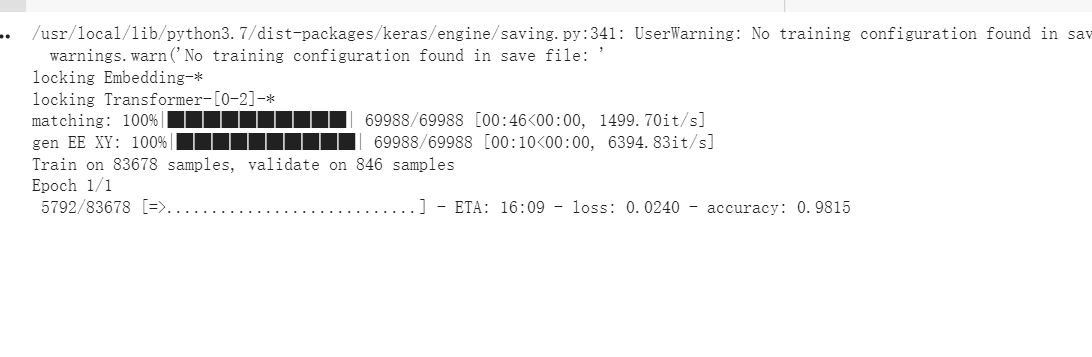

In [ ]:

ee = EEModel()
ee.train(trains, batch_size=32, epochs=20)
ee.predict(tests, threshold=thre_ee, ofile='valid_ee.json')
print('done')